In [1]:
## in this chapter I will explore diffenrnt classification techniques.
## sklearn provides multiple datasets we will pick the one of hand drawn numbers.
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784" , version=1)
## this returns a dictionary datastructure and the data in the data key and the target attribute in the target key

In [2]:
X , Y = mnist["data"] , mnist["target"]
print(X.shape,
Y.shape)

(70000, 784) (70000,)


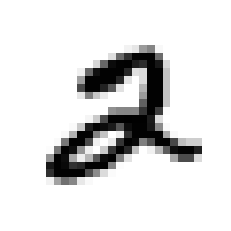

In [3]:
## lets see one of these images 
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

digit = X[5] ## array of pixel values. to display it must reshape it first
digit_image = digit.reshape(28, -1)

plt.imshow(digit_image , cmap="binary")

plt.axis("off")
plt.show()

##Y[5] this returns a string to numerate it 
Y = Y.astype(np.uint8)

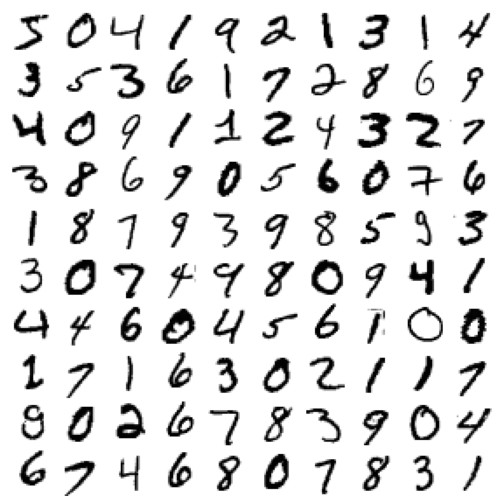

In [4]:
## now we want to plot multiple images.
## to do that using matplotlib use the following code
def plot_image(data):
    image = data.reshape(28,28)
    plt.imshow(image , cmap=mpl.cm.binary)
    plt.axis("off")


def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1

    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")


plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()
    

In [5]:
X_train , X_test , Y_train , Y_test = X[:60000] , X[60000:] , Y[:60000] , Y[60000:] 
## for now lets just mae it binary calssifier 5 or not 5

Y_train_5 = (Y_train == 5)
Y_test_5 = (Y_test ==5)

In [6]:
## now we will use a SDG classifer 
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,Y_train_5)

SGDClassifier(random_state=42)

In [7]:
## cross validation(will try implementing it from scratch not using cross_val_score()) 
from sklearn.model_selection import StratifiedKFold ## for folds that are representative
from sklearn.base import clone ## same as copy but for trained model 

folds = StratifiedKFold(n_splits=3 , shuffle=True, random_state=42)

for train_index , validation_index in folds.split(X_train, Y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    Y_train_folds = Y_train_5[train_index]
    X_validate = X_train[validation_index]
    Y_validate = Y_train_5[validation_index]

    clone_clf.fit(X_train_folds, Y_train_folds)
    predictions = clone_clf.predict(X_validate)
    correct_classifications = sum(Y_validate == predictions)
    print(correct_classifications / len(Y_validate))
     



0.9669
0.91625
0.96785


In [8]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf , X_train, Y_train_5 , cv= 3 , scoring="accuracy")
## this shit is so decivable you think those numbers are great , well try no classify the not 5s ( 1 of not 5 )



array([0.95035, 0.96035, 0.9604 ])

In [9]:
from sklearn.base import BaseEstimator 
## this makes a dump task when asked to predict it just returns an array of 1s sounds silly right but this will gain a 90%++ accuracy 
## as only 10% of the data is 5
class Never5Classifier( BaseEstimator ):
    def fit(self , X , y=None ):
        return self
    def predict(self , X):
        return np.zeros((len(X), 1), dtype=bool)


never_5 = Never5Classifier()
cross_val_score(never_5 , X_train , Y_train_5 , cv = 3 ,scoring="accuracy")

## this is a perfect demonstration that "accuracy" is a great measure of performance espically in skewed datasets.

array([0.91125, 0.90855, 0.90915])

In [10]:
## so instead we need to use the confusion matrix 

from sklearn.model_selection import cross_val_predict

Y_train_predictions = cross_val_predict(sgd_clf , X_train , Y_train_5 , cv =3)

In [11]:
Y_train_predictions.shape
from sklearn.metrics import confusion_matrix

confusion_matrix(Y_train_5 , Y_train_predictions)

## a perfect confusion matrix
Y_perfect = Y_train_5
confusion_matrix(Y_perfect, Y_train_5)
## a diagonal matrix with a diagonal sum equal to the training set len

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [12]:
## compute the F1 score instead ( a combination between precsion and accuracy )
from sklearn.metrics import f1_score
f1_score(Y_train_5,Y_train_predictions)
## check the f1 score equation online , you will find that it mostly prefers both the precision and the recall to have 
## close values , some problems may require to may attention to one over the other , well it is not possible to get both values to be high
## you just get one thing , so you must decide what is the metric you really care about.
## if for example you are training a calssifier that detects proper vids for kids then precision is more important(it is okay if we have 
## a vid that is good and calssified as bad but it is not okay to have a vid that is bad and classified as good )
## but for example if you trained a classifier to detect faces of theifs in shops recall is a better metric to pay attention to.
## you don't care if some buyers were classified wronlgy as theifs ( low precision ) but you care that all theifs are caught ( high recall)


0.7325171197343846

In [13]:
## the precision/recall tradeoff is a really important one to understand to further develop an inution of what it means lets 
## try to play with the SGD classifier we did , the way it works is that it outputs a certain score for every output and then it 
## checks this againstthe way SGD works

Y_scores = cross_val_predict(sgd_clf , X_train , Y_train_5 , cv = 3 , method ="decision_function")

In [14]:
## now lets plot those scores against diffenet thresholds  function precision_recall_curve 
from sklearn.metrics import precision_recall_curve
precisions , recalls , thresholds = precision_recall_curve(Y_train_5, Y_scores)


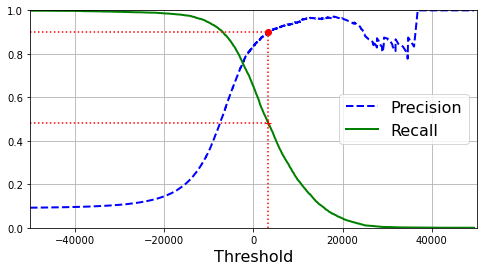

In [15]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])             



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "r+")                             
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

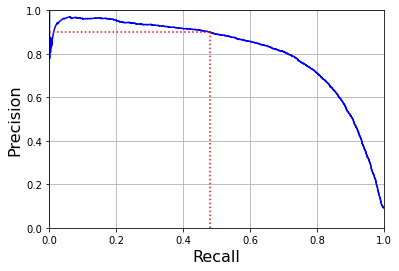

<Figure size 576x432 with 0 Axes>

In [16]:
plt.plot(recalls ,precisions , "b-" )
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:") 
plt.plot([0, recall_90_precision], [0.9, 0.9], "r:") 
plt.xlabel("Recall", fontsize=16)        
plt.ylabel("Precision", fontsize=16)       
plt.grid(True)                              
plt.axis([0,1, 0, 1])
plt.figure(figsize=(8, 6))                                                                  
plt.show                


In [17]:
threshold_90_precision
## well this will thresould will ensure a precision greater than 90% we can use it to recompute the predicted values
Y_train_predicted_at90 = ( Y_scores >= threshold_90_precision)

## and compute the precision and recall
from sklearn.metrics import precision_score,recall_score

print(precision_score(Y_train_5 , Y_train_predicted_at90))

recall_metric = recall_score(Y_train_5 , Y_train_predicted_at90 )
## as expected higher precision lower recall well there is no rules as stated before it is dependent on your project which one you should choose
## but it is a good idea to just plot and visualize things. 

0.9000345901072293


No handles with labels found to put in legend.


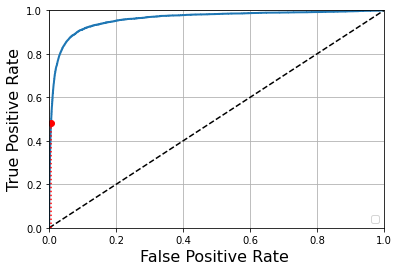

<Figure size 576x720 with 0 Axes>

In [18]:
## the ROC curve // the receiver operating characteristic this is the TPR(recall) against the (FPR)(1-TNR)(1-specificity)

from sklearn.metrics import roc_curve
fpr , tpr , thresholds = roc_curve( Y_train_5 , Y_scores)

FPR_at_certain_recall = fpr[np.argmax(tpr >= recall_metric)]

def plot_roc(fpr , tpr , label=None ):
    plt.legend(loc="lower right")
    plt.plot(fpr , tpr, linewidth = 2 , label = label)
    plt.plot([0,1],[0,1] ,'k--')
    plt.plot([FPR_at_certain_recall, FPR_at_certain_recall], [0, recall_metric], "r:") 
    plt.plot([FPR_at_certain_recall], [recall_metric], "ro")                                             
    plt.xlabel("False Positive Rate ",fontsize=16)        
    plt.ylabel("True Positive Rate", fontsize=16)       
    plt.grid(True)                              
    plt.axis([0,1, 0, 1])
    plt.figure(figsize=(8, 10)) 
 

plot_roc(fpr , tpr , thresholds)

# this plot is a a great way to compute classifiers the more the curve moves to the dotted line the worse it is it 
## here the value choosen for the recall yields an accepted FPR ( almost zero )

In [19]:
## measuring the area under the curve mifht also be a great ay to meausre a great classifier a perfect classifier will have an ROC very close to 1
## a rnadom one will have as expected from the graph a 0.5 area 

from sklearn.metrics import roc_auc_score

roc_auc_score(Y_train_5 , Y_scores)

## wondering which one to use when ? well , it depends on the nature of data 
## if we have rare positive class like in this problem the 5 is rare so use PR or whenever you care more about false positives than you do 
## with false nrgatives. this is a a great example here the ROC AUC is 96 however that PR curve shows that the performance in in the 80s in terms 
## of precison



0.9604938554008616

In [20]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

Y_probas_forest = cross_val_predict(forest_clf , X_train , Y_train_5 , cv = 3 ,method="predict_proba" )

In [21]:
Y_scores_forest = Y_probas_forest[: , 1]
fpr_forest , tpr_forest , thesholds = roc_curve(Y_train_5 , Y_scores_forest)

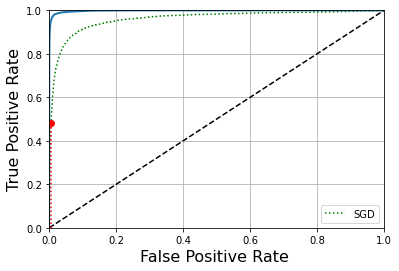

<Figure size 576x720 with 0 Axes>

In [22]:
plt.plot(fpr , tpr , "g:" , label="SGD")
plot_roc(fpr_forest , tpr_forest , label="Random forest")
plt.show()

In [23]:
print(roc_auc_score(Y_train_5 , Y_scores_forest))
y_prediction_rf = cross_val_predict(forest_clf, X_train , Y_train_5 , cv=3)

print(precision_score(Y_train_5 , y_prediction_rf))
print(recall_score(Y_train_5, y_prediction_rf))

0.9983436731328145
0.9905083315756169
0.8662608374838591


## MultiClass calssification

In [24]:
## when it comes to multiclass classification it really depends on the algorithm being used some algorithms are already designed to deal 
## with multiple classifications other are not svm and LR are for example designed to deal with binary classifications.

## OVO and OVA

from  sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, Y_train)
svm_clf.predict([digit])



array([2], dtype=uint8)

In [25]:
scores_svm = svm_clf.decision_function([digit])
scores_svm
## by default SVM used OVO and the class that wins the duals wins but you can force using OVA 
from sklearn.multiclass import OneVsRestClassifier

##ovr_svm_clf = OneVsRestClassifier(SVC())
##ovr_svm_clf.fit(X_train,Y_train)
## this lines take too long and that explains that SVM is great with binary classifications or OVO ,
## training small number classifiers on big data is worse that training big number of classifiers on small chunks of data

In [26]:
# training the SGD is just as simple

sgd_clf.fit(X_train , Y_train)
sgd_clf.predict([digit])
sgd_clf.decision_function([digit])
cross_val_score(sgd_clf , X_train,Y_train , cv=3 , scoring="accuracy")
## f1 score will not make much of a diffenrce here as there are 10 classes

array([0.87365, 0.85835, 0.8689 ])

In [27]:
## rember the data does not have a 0 mean scaling them will surly improve the performance

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf , X_train_scaled ,Y_train, cv=3 , scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Error Analysis

In [28]:
Y_train_predictions = cross_val_predict(sgd_clf, X_train_scaled , Y_train , cv =3)
conf_mx=confusion_matrix(Y_train , Y_train_predictions)

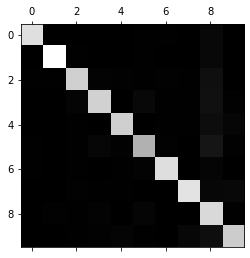

In [29]:
## to better visualize the matrix plot its BW image equiv.
plt.matshow(conf_mx , cmap=plt.cm.gray)

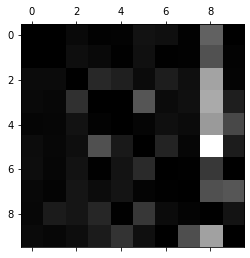

In [31]:
##The above image is not really normalized that is if a ceratain index in the matrix is 31 , we need to know this is 31 according to what value
## so we sum the row and normalize the values.

row_sums = conf_mx.sum(axis = 1 , keepdims = True)
normalized_mat = conf_mx / row_sums

## we also knew that the diagonal is realtivly bright so we may need to ignore them for now to focus on the rest of the data

np.fill_diagonal(normalized_mat , 0 )
plt.matshow(normalized_mat , cmap=plt.cm.gray)

## usefull information could be gathered from those figs , it seems that there are many false 8 classifications this might be a problem
## you can tackle this maybe by adding another feature that makes the 8 unique no of closed loops for example you can use openCv for this.


## there are also some false calssifications 6,5 are sometimes confused 2,3 as well this is expected as the style of numbers might sometimes 
## confuse humans themselves ,yet 5 and 3 is the most obvious one , it looks very wierd soo visualizing your data might help 
## or give some insights.



In [33]:
X_train_33 = X_train[(Y_train == 3) & (Y_train_predictions == 3)]
X_train_35 = X_train[(Y_train == 3) & (Y_train_predictions == 5)]
X_train_55 = X_train[(Y_train == 5) & (Y_train_predictions == 5)]
X_train_53 = X_train[(Y_train == 5) & (Y_train_predictions == 3)]

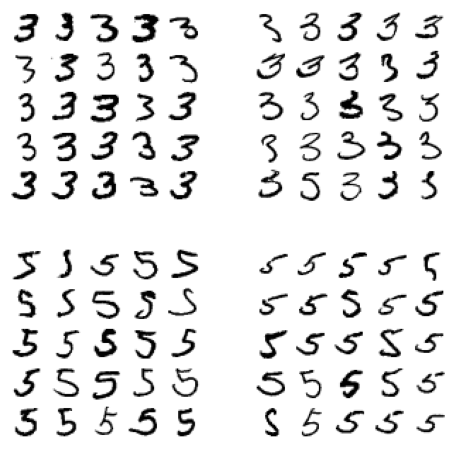

In [34]:
plt.figure(figsize=(8,8))
## pick 25 images form each class we have
plt.subplot(221); plot_digits(X_train_33[:25] , images_per_row=5)
plt.subplot(222); plot_digits(X_train_35[:25] , images_per_row=5)
plt.subplot(223); plot_digits(X_train_53[:25] , images_per_row=5)
plt.subplot(224); plot_digits(X_train_55[:25] , images_per_row=5)



# Multilabel Classification

In [35]:
from sklearn.neighbors import KNeighborsClassifier
Y_train_greater7 = ( Y_train >= 7 )
Y_train_odd = (Y_train % 2 == 1)
Y_train_multilabel = np.c_[Y_train_greater7 , Y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train , Y_train_multilabel)

KNeighborsClassifier()

In [36]:
knn_clf.predict([digit])
## hoaay false false is what we predicted

array([[False, False]])

# warning : this block can take up to hours to finish running

In [37]:
## cross val score can also be used with multilabel classification , the function averages the error of all the labels not the best way but
## it depends on your problem.

y_train_knn_predict = cross_val_predict(knn_clf , X_train , Y_train_multilabel , cv = 3)
f1_score(Y_train_multilabel , y_train_knn_predict , average="macro") 

## you may want the average to be wighted by some value here the number of classes with a certain label
## that is the numbers that are odd are only 1000/60000 then we give this label while averageing a wight of 1/6 and so on
## set the average="weighted" to do this.


0.976410265560605

# Multioutput classificaation

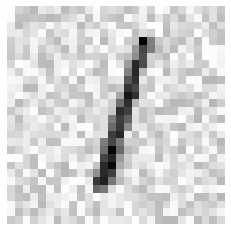

In [38]:
noise = np.random.randint(0,100,(len(X_train),784))
X_train_noisy = X_train + noise
noise_test = np.random.randint(0 , 100 , (len(X_test), 784))
X_test_noisy = X_test + noise_test

## Now the X_train is the expected output so set the Y_train by X_train

Y_train_noise = X_train
Y_test_noise = X_test

## to verify let us look at an example
digit_noise = X_test_noisy[2] ## array of pixel values. to display it must reshape it first
digit_image = digit_noise.reshape(28, -1)

plt.imshow(digit_image , cmap="binary")

plt.axis("off")
plt.show()

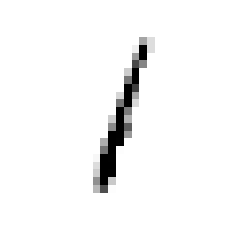

In [40]:
knn_clf.fit(X_train_noisy, Y_train_noise)
not_noise = knn_clf.predict([X_test_noisy[2]])
digit_image_clean = not_noise.reshape(28, -1)

plt.imshow(digit_image_clean , cmap="binary")

plt.axis("off")
plt.show()